In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces, logger
from gym.utils import seeding
from scipy.integrate import odeint
from tqdm import tqdm
import os
import torch.nn as nn
import torch as T
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.integrate import odeint
from scipy.optimize import minimize

In [2]:
def PID(setpoint):
    # process model
    Kp = 3.0
    taup = 5.0
    delay = 25
    def process(y,t,u,Kp,taup):
        # Kp = process gain
        # taup = process time constant
        dydt = -y/taup + Kp/taup * u
        return dydt

    # specify number of steps
    ns = 300
    # define time points
    t = np.linspace(0,ns/10,ns+1)
    delta_t = t[1]-t[0]

    # storage for recording values
    op = np.zeros(ns+1)  # controller output
    pv = np.zeros(ns+1)  # process variable
    e = np.zeros(ns+1)   # error
    ie = np.zeros(ns+1)  # integral of the error
    dpv = np.zeros(ns+1) # derivative of the pv
    P = np.zeros(ns+1)   # proportional
    I = np.zeros(ns+1)   # integral
    D = np.zeros(ns+1)   # derivative
    sp = np.zeros(ns+1)  # set point
    sp = setpoint
    # PID (starting point)
    Kc = 1.0/Kp
    tauI = taup
    tauD = 0.0

    # PID (tuning)
    Kc = Kc * 2
    tauI = tauI / 2
    tauD = 1.0

    # Upper and Lower limits on OP
    op_hi = 100.0
    op_lo = 0.0
    diff = 0
    # loop through time steps    
    for i in tqdm(range(0,ns)):
        e[i] = sp[i] - pv[i]
        if i >= 1:  # calculate starting on second cycle
            dpv[i] = (pv[i]-pv[i-1])/delta_t
            ie[i] = ie[i-1] + e[i] * delta_t
        P[i] = Kc * e[i]
        I[i] = Kc/tauI * ie[i]
        D[i] = - Kc * tauD * dpv[i]
        op[i] = op[0] + P[i] + I[i] + D[i]
        if op[i] > op_hi:  # check upper limit
            op[i] = op_hi
            ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
        if op[i] < op_lo:  # check lower limit
            op[i] = op_lo
            ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
        y = odeint(process,pv[i],[0,delta_t],args=(op[int(max(0,i-delay))],Kp,taup))
        pv[i+1] = y[-1]
        diff += abs(pv[i+1]-sp[i])
    op[ns] = op[ns-1]
    ie[ns] = ie[ns-1]
    P[ns] = P[ns-1]
    I[ns] = I[ns-1]
    D[ns] = D[ns-1]

    return (pv)

In [3]:
def MPC(setpoint): 

    # Define process model
    def process_model(y,t,u,K,tau):
        # arguments
        #  y   = outputs
        #  t   = time
        #  u   = input value
        #  K   = process gain
        #  tau = process time constant

        # calculate derivative
        dydt = (-y + K * u)/(tau)
        return dydt

    # Define Objective function      
    def objective(u_hat):
        # Prediction
        for k in range(1,2*P+1):
            if k==1:
                y_hat0 = yp[i-P]
            if k<=P:
                if i-P+k<0:
                    u_hat[k] = 0
                else:
                    u_hat[k] = u[i-P+k]
            elif k>P+M:
                u_hat[k] = u_hat[P+M]

            ts_hat = [delta_t_hat*(k-1),delta_t_hat*(k)]        
            y_hat = odeint(process_model,y_hat0,ts_hat,args=(u_hat[k],K,tau))
            y_hat0 = y_hat[-1]
            yp_hat[k] = y_hat[0]

            # Squared Error calculation
            sp_hat[k] = sp[i]
            delta_u_hat = np.zeros(2*P+1)        

            if k>P:
                delta_u_hat[k] = u_hat[k]-u_hat[k-1]
                se[k] = abs(sp_hat[k]-yp_hat[k]) + 20*abs(delta_u_hat[k])

        # Sum of Squared Error calculation      
        obj = np.sum(se[P+1:])
        return obj
    # FOPDT Parameters
    K=3.0      # gain
    tau=5.0    # time constant
    ns = 300    # Simulation Length
    t = np.linspace(0,ns,ns+1)
    delta_t = t[1]-t[0]

    # Define horizons
    P = 20 # Prediction Horizon
    M = 5 # Control Horizon

    # Input Sequence
    u = np.zeros(ns+1)

    # Setpoint Sequence
    sp = np.zeros(ns+1+2*P)
    sp[:len(setpoint)] = setpoint
    sp[len(setpoint):] = 0
    # Controller setting
    maxmove = 100

    ## Process simulation
    yp = np.zeros(ns+1)
    
    for i in tqdm(range(1,ns+1)):
        if i==1:
            y0 = 0
        ts = [delta_t*(i-1),delta_t*i]
        y = odeint(process_model,y0,ts,args=(u[i],K,tau))
        y0 = y[-1]
        yp[i] = y[0]

        # Declare the variables in fuctions
        t_hat = np.linspace(i-P,i+P,2*P+1)
        delta_t_hat = t_hat[1]-t_hat[0]
        se = np.zeros(2*P+1)
        yp_hat = np.zeros(2*P+1)
        u_hat0 = np.zeros(2*P+1)
        sp_hat = np.zeros(2*P+1)
        obj = 0.0

        # initial guesses
        for k in range(1,2*P+1):

            if k<=P:
                if i-P+k<0:
                    u_hat0[k] = 0

                else:
                    u_hat0[k] = u[i-P+k]

            elif k>P:
                u_hat0[k] = u[i]

        # show initial objective

        # if i%25==0:
        #  print('Initial SSE Objective: ' + str(objective(u_hat0)))

        # MPC calculation
        # start = time.time()

        solution = minimize(objective,u_hat0,method='SLSQP',)
        u_hat = solution.x  

        # end = time.time()
        # elapsed = end - start

        # print('Elapsed time: ' + str(elapsed) )

        delta = np.diff(u_hat)

        if i<ns:    
            if np.abs(delta[P]) >= maxmove:
                if delta[P] > 0:
                    u[i+1] = u[i]+maxmove
                else:
                    u[i+1] = u[i]-maxmove

            else:
                u[i+1] = u[i]+delta[P]
        
    return (yp)

100%|██████████| 300/300 [00:00<00:00, 9331.39it/s]


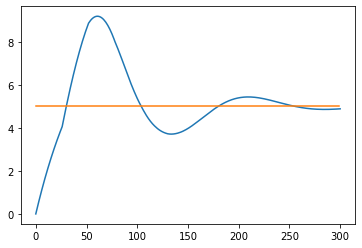

In [4]:
plt.plot(PID([5]*300))
plt.plot([5]*300)

In [5]:
class Agent():
    def __init__(self, alpha, beta, input_dims, tau, n_actions, gamma=0.99,
                max_size=100000, fc1_dims=400, fc2_dims=300, 
                batch_size=128):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='actor')
        self.critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='critic')

        self.target_actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_actor')

        self.target_critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(), 
                                    dtype=T.float).to(self.actor.device)
        self.actor.train()

        return mu_prime.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, states_, done = \
                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                (1-tau)*target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)
        #self.target_critic.load_state_dict(critic_state_dict, strict=False)
        #self.target_actor.load_state_dict(actor_state_dict, strict=False)

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                chkpt_dir='content/tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        
        self.q = nn.Linear(self.fc2_dims, 1)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)

        f4 = 1./np.sqrt(self.action_value.weight.data.size()[0])
        self.action_value.weight.data.uniform_(-f4, f4)
        self.action_value.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        #state_value = F.relu(state_value)
        #action_value = F.relu(self.action_value(action))
        action_value = self.action_value(action)
        state_action_value = F.relu(T.add(state_value, action_value))
        #state_action_value = T.add(state_value, action_value)
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                chkpt_dir='content/tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f3 = 0.003
        self.mu.weight.data.uniform_(-f3, f3)
        self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #x = T.tanh(self.mu(x))
        x = self.mu(x)
        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

class Process(gym.Env):
    def __init__(self, n_yt, n_ut, n_rew, setpoint):
      self.Kp = 3.0
      self.taup = 5.0
      self.delta_t = 0.1
      self.steps = 0
      self.count = 0
      self.n_yt = n_yt
      self.n_ut = n_ut
      self.n_rew = n_rew
      self.eps = 1e-5
      # setpoint = [0]*100 + [5]*100 + [10]*100

      dim = self.n_yt+self.n_ut+self.n_rew
      self.dim = dim
      self.setpoint = np.array(setpoint)
      self.state = np.array([0]*dim, dtype=np.float32)

      state_high = np.array([100.0]*dim, dtype=np.float)
      state_low = np.array([0.0]*dim, dtype=np.float)
      action_high = np.array([100.0], dtype=np.float)
      action_low = np.array([0.0], dtype=np.float)

      self.observation_space = spaces.Box(state_low, state_high, dtype=np.float32)
      self.action_space = spaces.Box(action_low, action_high, dtype=np.float32)


    def process(self,y,t,action):
      # Kp = process gain
      # taup = process time constant
        dydt = -y/self.taup + self.Kp*action/self.taup
        return dydt

    def step(self, act):
      st_2, st_1, st_0, _ = self.state[0], self.state[1:self.n_yt-1], self.state[self.n_yt-1], self.state[self.n_yt:]
    #      st__1 = odeint(self.process,st_0,[0,self.delta_t],args=(act[-1],))[-1][0]
      st__1 = self.Kp*(1-np.exp(-self.steps/self.taup))*act[-1]
      self.steps += 1
      reward = -np.abs(st__1-self.setpoint[self.steps-1])
      
      st_1 = np.append(st_1, [st_0, st__1])
      st_1 = np.append(st_1, [act])
      self.state = np.append(st_1, [reward])
      done = bool(self.steps>=300)

      return (self.state, reward, done, {})

    def reset(self):
      self.state = [0]*self.dim
      self.steps = 0
      self.count = 0
      return np.array(self.state)

In [6]:
def DRL(setpoint):

    setpoint = setpoint
    n_yt = 2
    n_ut = 1
    n_prev_reward = 1
    env = Process(n_yt,n_ut,n_prev_reward, setpoint)
    n_games = 200
    fc1_dims = 400
    fc2_dims = 300
    agent = Agent(alpha=0.001, beta=0.001, input_dims = env.observation_space.shape, tau = 0.01, batch_size = 128, n_actions = env.action_space.shape[0], fc1_dims = 400 , fc2_dims = 300)
    f_name = 'SISO_alpha' + str(agent.alpha) + 'beta_' + str(agent.beta) + '_' + str(n_games) + '_' + 'Episodes' + 'fc1_dims_' + str(fc1_dims) + '_' + 'fc2_dims_' + str(fc2_dims) 
    figure_file = 'plots/' + f_name + '.png'

    best_score = env.reward_range[0]
    scores = []
    Actions = []
    Observations = []
    best = 0
    for i in tqdm(range(n_games)):
        obs = env.reset()
        act = [0]*n_ut
        prev_reward = [0]*n_prev_reward
        score = 0
        done = False
        agent.noise.reset()
        Action = []
        Observation = []
        while not done:
          action = agent.choose_action(obs)
          if act: act.pop(0)
          act.append(action[0])
          Action.append(action[0])
          
          Observation.append(obs[n_yt-1])
          obs_, reward, done, info = env.step(act)

          prev_reward.pop(0)
          prev_reward.append(reward)

          agent.remember(obs, action, reward, obs_, done)
          score += reward
          agent.learn()
          obs = obs_
        
        scores.append(score)
        avg_score = np.mean(scores[-10:])
        
        if avg_score>best_score:
            best_score = avg_score
            best = i
            # agent.save_models()
        Actions.append(Action)
        Observations.append(Observation)
        
    return (Observations[best])

In [7]:
def Plots(i,setpoint):
    y1 = PID(setpoint)
    y2 = MPC(setpoint)
    y3 = DRL(setpoint)
    
    digit = str(i)
    name1 = 'PID'+digit
    name2 = 'MPC'+digit
    name3 = 'DDPG'+digit
    
    a_file = open(name1, "w")
    np.savetxt(a_file, y1[1:])
    a_file.close()

    a_file = open(name2, "w")
    np.savetxt(a_file, y2[1:])
    a_file.close()

    a_file = open(name3, "w")
    np.savetxt(a_file, y3)
    a_file.close()
    
    print("PID:{}".format(sum(np.abs(setpoint-y1[1:]))))
    print("MPC:{}".format(sum(np.abs(setpoint-y2[1:]))))
    print("DRL:{}".format(sum(np.abs(setpoint-np.array(y3)))))
    print("\n")
    
    plt.figure(figsize=(15,5))
    plt.plot(setpoint)
    plt.plot(y1, label='PID')
    plt.plot(y2[1:], label='MPC')
    plt.plot(y3, label='DRL')
    plt.legend()
    plt.show()
    
    print("\n")

100%|██████████| 300/300 [15:31<00:00,  3.11s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [11:39<00:00,  3.50s/it]

PID:68.57711160854421
MPC:6.855980128925659
DRL:140.7734807988353




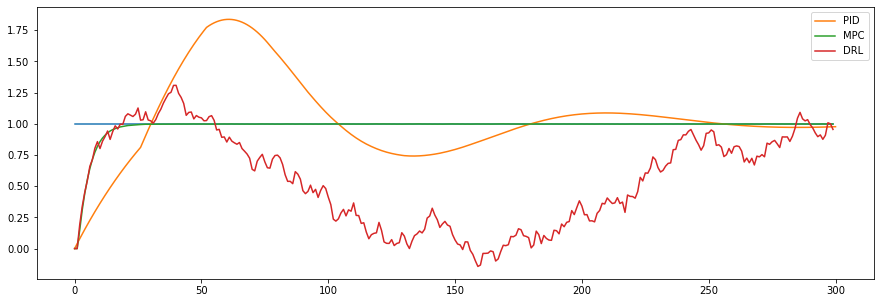

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [15:48<00:00,  3.16s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [11:41<00:00,  3.51s/it]


PID:342.8857418036871
MPC:34.835279704350015
DRL:90.30828623246715




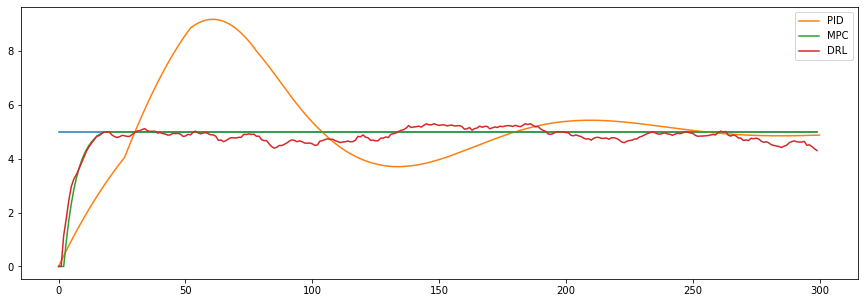

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [14:17<00:00,  2.86s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [11:41<00:00,  3.51s/it]

PID:685.7715144940096
MPC:58.17242510405915
DRL:116.40314031653423




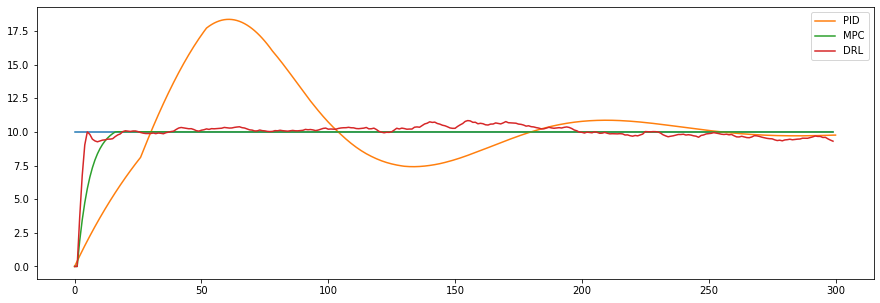

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [13:39<00:00,  2.73s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [11:45<00:00,  3.53s/it]

PID:3428.857672043401
MPC:290.0172273888212
DRL:365.31125078131106




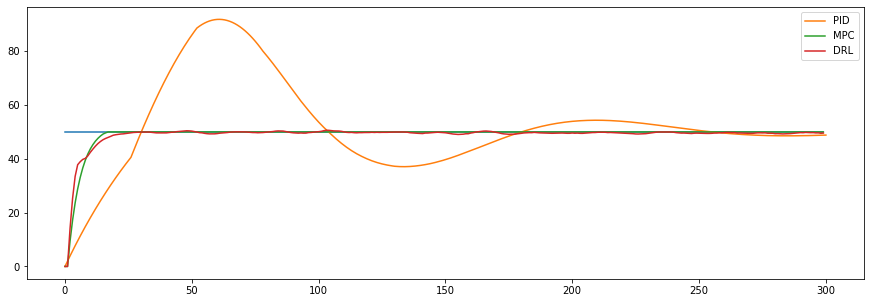

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [15:28<00:00,  3.09s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [11:44<00:00,  3.52s/it]

PID:6231.297989599456
MPC:732.4860012285526
DRL:654.9862677516155




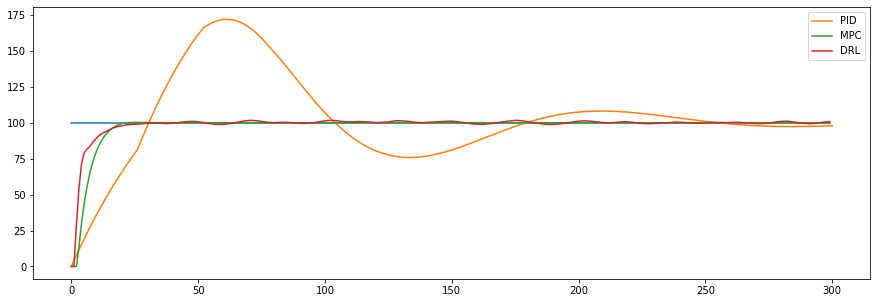

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [15:24<00:00,  3.08s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [11:50<00:00,  3.55s/it]


PID:78.70221580942851
MPC:5.638836216211776
DRL:72.32763430031792




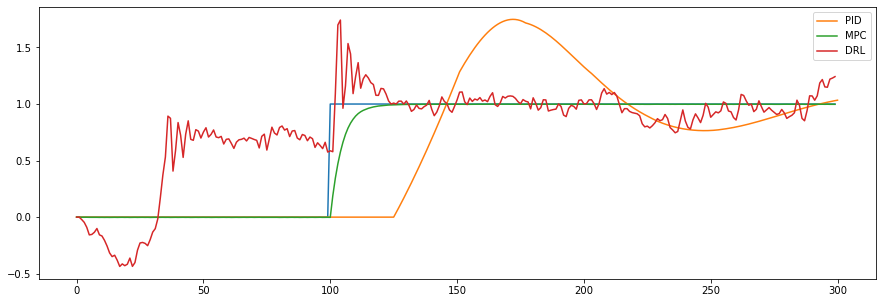

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [16:06<00:00,  3.22s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [11:48<00:00,  3.54s/it]

PID:393.51112294256234
MPC:24.265836088101178
DRL:47.303390060035454




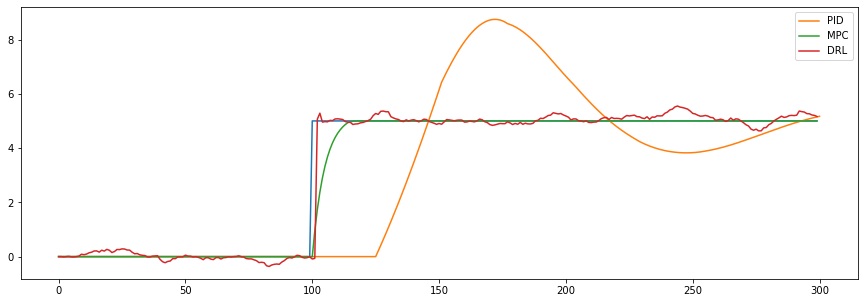

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [16:23<00:00,  3.28s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [12:39<00:00,  3.80s/it]


PID:787.022269280957
MPC:54.68180444490629
DRL:72.67786170323934




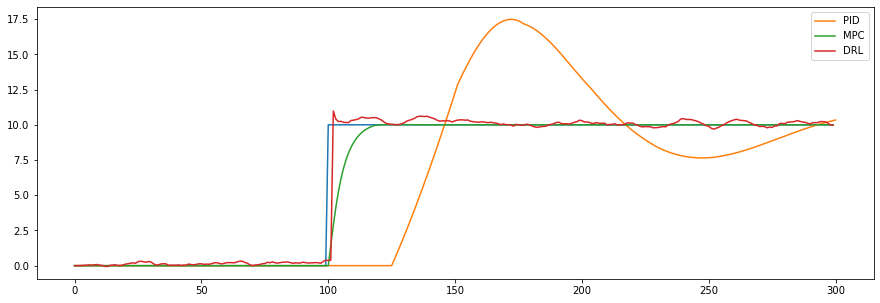

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [16:06<00:00,  3.22s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [11:56<00:00,  3.58s/it]


PID:3935.111447448859
MPC:244.6482446014266
DRL:193.1048293478553




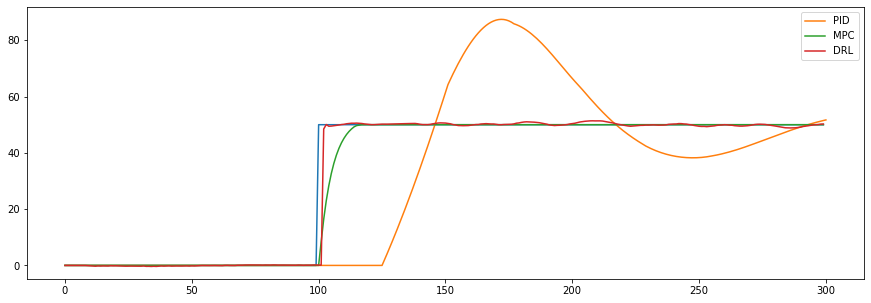

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [17:04<00:00,  3.41s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [12:12<00:00,  3.66s/it]


PID:5213.636653695152
MPC:514.3783509574761
DRL:4338.257130830254




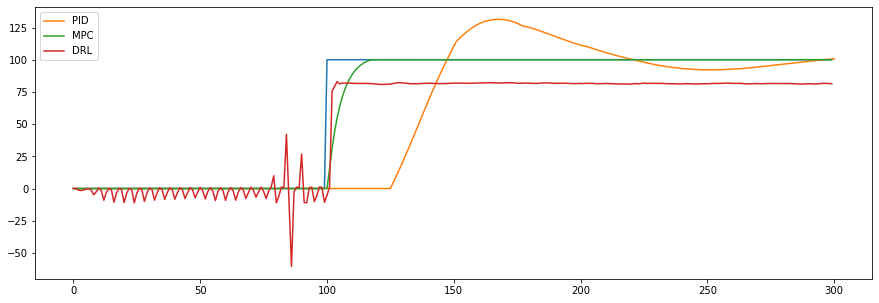

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [23:54<00:00,  4.78s/it]
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [12:09<00:00,  3.65s/it]

PID:1284.117901009333
MPC:150.28210593072308
DRL:191.3226002033586




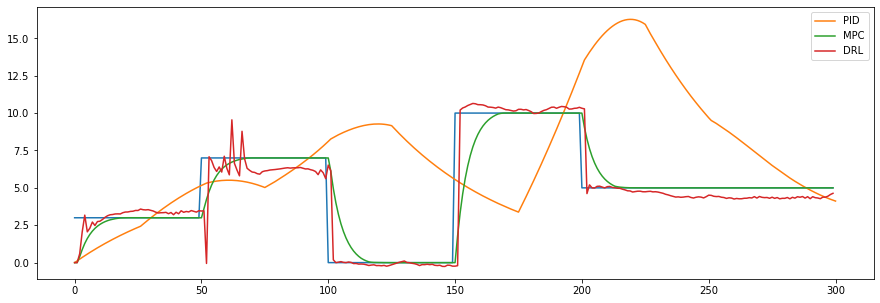

In [8]:
Setpoints = [[1]*300,[5]*300,[10]*300,[50]*300,[100]*300,[0]*100+[1]*200,[0]*100+[5]*200,[0]*100+[10]*200,[0]*100+[50]*200,[0]*100+[100]*200,[3]*50 + [7]*50 + [0]*50 + [10]*50 + [5]*100]

for i,setpoint in enumerate(Setpoints):
    Plots(i,setpoint)